Install dependencies in colab

In [1]:
! pip install -q scipy numpy torch pandas tqdm torchinfo

In [2]:
import scipy.io
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import tqdm
torch.manual_seed(0);

- 48 numerical features
- 1 target

In [3]:
data = scipy.io.loadmat('OQC.mat')
data = pd.DataFrame(data.get('data'))
data.head()

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,0.390525,0.147798,0.156398,0.00256,0.555556,0.777778,0.555556,0.714286,0.50,0.5,...,0.719864,0.037255,0.329627,1.0,0.000038,0.125,0.078970,0.079625,0.922469,2.0
1,0.390525,0.147798,0.156398,0.00256,0.444444,0.666667,0.555556,0.714286,0.25,0.5,...,0.719864,0.072549,0.328711,1.0,0.000038,0.125,0.053677,0.053677,0.921482,2.0
2,0.508494,0.147798,0.156398,0.00256,0.444444,0.666667,0.555556,0.714286,0.25,0.5,...,0.842105,0.994118,0.326533,1.0,0.000038,0.125,0.056112,0.056112,0.920494,2.0
3,0.577954,0.147798,0.156398,0.00256,0.444444,0.666667,0.444444,0.571429,0.50,0.5,...,0.877759,0.994118,0.326533,1.0,0.000038,0.125,0.056206,0.057424,0.920494,2.0
4,0.649490,0.147798,0.156398,0.00256,0.555556,0.666667,0.444444,0.571429,0.50,0.5,...,0.874363,0.996078,0.323210,1.0,0.000038,0.125,0.057705,0.056112,0.920000,2.0


- small dataset
    - model cannot have too many parameters
    - otherwise very likely to overfit

In [4]:
features = data.iloc[:, :-1].values
targets = data.iloc[:, -1].values
features.shape, targets.shape

((2952, 48), (2952,))

In [5]:
features = torch.tensor(features).float() # float64 to float32
targets = torch.tensor(targets).long() # cast to int64
features.dtype, targets.dtype

(torch.float32, torch.int64)

- 70/30 `train`/`valid` split

In [6]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(features, targets, test_size= 0.3, random_state=42)

Helper function to:
- retrieve batches of (x, y) and pass them to gpu with `collate_fn`

In [7]:
from torch.utils.data.dataloader import default_collate

def init_loaders(batch_size=1, device='cuda'):
    # collate_fn moves each batch to gpu
    train_loader = DataLoader(list(zip(x_train, y_train)),
                              batch_size=batch_size,
                              shuffle=True,
                              collate_fn=lambda x: list(x_.to(device) for x_ in default_collate(x)))
    valid_loader = DataLoader(list(zip(x_valid, y_valid)),
                            batch_size=batch_size,
                            shuffle=True,
                            collate_fn=lambda x: list(x_.to(device) for x_ in default_collate(x)))
    return dict(train=train_loader, valid=valid_loader)

In [8]:
dataloaders = init_loaders()

Peek at data:
- 48 features
- 1 target
- all on gpu (`cuda`)

In [9]:
for x, y in dataloaders['valid']:
    break
x, y

(tensor([[8.8184e-01, 1.2705e-01, 3.9810e-01, 1.7693e-03, 4.4444e-01, 6.6667e-01,
          4.4444e-01, 5.7143e-01, 2.5000e-01, 5.7143e-01, 2.5000e-01, 2.5000e-01,
          3.3187e-01, 9.9439e-01, 8.3245e-01, 6.3636e-01, 3.7500e-01, 3.7500e-01,
          5.0000e-01, 3.3333e-01, 5.0000e-01, 7.4074e-02, 3.0623e-01, 3.3333e-01,
          5.0000e-01, 2.6667e-01, 6.9377e-01, 6.1453e-01, 3.8547e-01, 9.2589e-01,
          1.0000e+00, 9.9213e-01, 4.9981e-02, 2.2996e-01, 1.0000e+00, 6.5889e-01,
          4.6657e-01, 6.3312e-01, 5.3298e-02, 8.7946e-01, 9.9608e-01, 9.3067e-02,
          1.0000e+00, 3.7652e-05, 1.2500e-01, 5.7611e-02, 5.7611e-02, 9.2593e-01]],
        device='cuda:0'),
 tensor([1], device='cuda:0'))

# Task 1
Helper function for 1 Epoch
- for `train` and `valid`
    - for each minibatch
        - pass minibatch through model
        - get predictions
        - calculate loss, acc
        - if `train` then update weights
        - log results

In [10]:
def train_valid(model,
                dataloaders,
                optimizer,
                epoch,
                history,
                log_interval=10 ** 3,
                verbose=False,
                device='cuda'):
    for phase in ['train', 'valid']:
        if phase == 'train':
            model.train() # enable stuff like dropout
        else:
            model.eval() # disable stuff like dropout
            
        running_correct = 0
        running_loss = 0
        running_acc = 0
        dataloader = dataloaders[phase]
        progress_bar = tqdm.notebook.tqdm(dataloader) if verbose else dataloader
        
        for batch_idx, (feature, target) in enumerate(progress_bar):
            
            if batch_idx == 0: # last
                batch_size = len(target) # last len(target) may be < batch_size
                
            optimizer.zero_grad() # torch accumulates grads (easier for nets like RNNs)
            
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                output = model(feature)
                _, preds = torch.max(output, dim=-1)
                loss = F.cross_entropy(output, target, reduction='sum') # use once only so use lower level function
            
                if phase == 'train':
                    loss.backward() # computes (partial) derivatives
                    optimizer.step() # w -= alpha * (partial) derivatives

            running_loss += loss.item()
            correct = torch.sum(preds == target).cpu().item() # pass to cpu for use later
            running_correct += correct
            running_acc += correct / len(target)

            if verbose and batch_idx % log_interval == 0:
                log = '------\tEpoch: {} | {}_loss: {:.6f} | {}_acc : {:.6f}\t------'.format(
                    epoch, phase, loss.item(), phase, correct / len(target))
                progress_bar.set_description(log)
                progress_bar.refresh()

        epoch_loss = running_loss / len(dataloader)
        epoch_acc = running_correct / (len(dataloader) * batch_size)
        history.get(f'{phase}_loss').append(epoch_loss)
        history.get(f'{phase}_acc').append(epoch_acc)
    
    return history

- 48 input features
- 3 class classification problem

In [11]:
input_size = len(features[0])
num_classes = len(np.unique(targets))
input_size, num_classes

(48, 3)

Helper class to construct model with varying neurons (width) and hidden layers (depth)

In [12]:
class Model(nn.Module):
    def __init__(self, neurons, hidden_layers):
        super().__init__()
        self.fc1 = nn.Linear(input_size, neurons)
        self.relu = nn.ReLU(inplace=True)

        layers = list()
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(neurons, neurons))
            layers.append(nn.ReLU(inplace=True))
            
        self.layers = nn.Sequential(*layers) if layers != list() else list()
        self.clf = nn.Linear(neurons, num_classes)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        
        for layer in self.layers:
            x = layer(x)
            
        x = self.clf(x)
        return x

Helper function to:
- create model
- run `train_valid` for each epoch

In [13]:
import torchinfo

def run_network(neurons=4,
                batch_size=16,
                hidden_layers=2,
                lr=.01,
                gamma=1,
                epochs=20,
                device='cuda',
                verbose=False,
                summary=False,
                scheduler='step'):
    
    dataloaders = init_loaders(batch_size, device)
    model = Model(neurons=neurons, hidden_layers=hidden_layers).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    if scheduler == 'step':
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=gamma)
    elif scheduler == 'cyclic':
        scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=lr // 10, max_lr=lr)
    else:
        raise ValueError(f'Unknown scheduler {scheduler}')
    history = {k: list() for k in ['train_loss', 'valid_loss', 'train_acc', 'valid_acc']}
    
    if summary:
        print(torchinfo.summary(model, input_size=[batch_size, input_size]))

    for epoch in range(1, epochs + 1):
        history = train_valid(model=model,
                              dataloaders=dataloaders,
                              optimizer=optimizer,
                              epoch=epoch,
                              history=history,
                              verbose=verbose,
                              device=device)
        scheduler.step()
    return history

In [14]:
%%time

# 3 layer
vanilla_results = run_network(summary=True, verbose=True)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    --                        --
├─Linear: 1-1                            [16, 4]                   196
├─ReLU: 1-2                              [16, 4]                   --
├─Sequential: 1                          --                        --
│    └─Linear: 2-1                       [16, 4]                   20
│    └─ReLU: 2-2                         [16, 4]                   --
├─Linear: 1-3                            [16, 3]                   15
Total params: 231
Trainable params: 231
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01


  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

CPU times: user 3.66 s, sys: 116 ms, total: 3.78 s
Wall time: 3.67 s


Helper function to visualize loss and accuracy

In [15]:
import matplotlib.pyplot as plt

def plot(history, suptitle_label=''):
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    f.subplots_adjust(top=.75 if suptitle_label == '' else .7)

    train_acc = history['train_acc']
    train_loss = history['train_loss']
    valid_acc = history['valid_acc']
    valid_loss = history['valid_loss']
    
    axes[1].plot(history['train_acc'])
    axes[1].plot(history['valid_acc'])
    axes[1].set_title('Model acc')
    axes[1].set(ylabel = 'acc', xlabel = 'Epoch')
    axes[1].legend(['Train', 'Valid'], loc='upper left')
    axes[0].plot(history['train_loss'])
    axes[0].plot(history['valid_loss'])
    axes[0].set_title('Model loss')
    axes[0].set(ylabel = 'loss', xlabel = 'Epoch')
    axes[0].legend(['Train', 'valid'], loc='upper left')
    axes[0].grid()
    axes[1].grid()
    
    title = (
        f'{suptitle_label}\n' +
        'Min Training loss: {:.{}f}\n'.format(np.min(train_loss), 3) +
        'Max Training acc: {:.{}f}\n'.format(np.max(train_acc), 3) +
        'Min Validation loss: {:.{}f} <--\n'.format(np.min(valid_loss), 3) +
        'Max Validation acc: {:.{}f}\n'.format(np.max(valid_acc), 3)
    )
    f.suptitle(title)

For the default hyperparameters:
- performance is decent
- but declines around epoch 16

The following will be varied to see if this performance can be improved (lowest `valid` error)
- `neurons` (width), `hidden_layers` (depth)
- `lr`
    - static
    - schedule
- `batch_size`

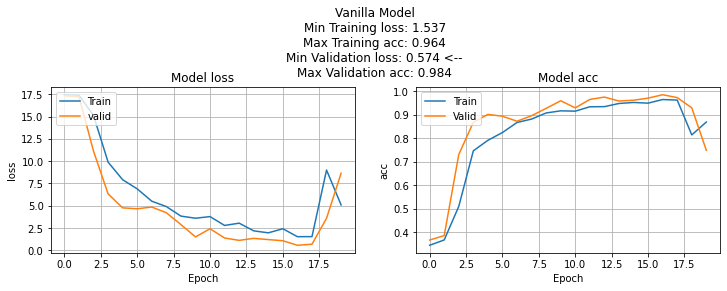

In [16]:
plot(vanilla_results, 'Vanilla Model')

## Task 2
You are asked to study the effect of network structure: hidden nodes, hidden layers to the classification
performance. That is, you try different network configurations and understand the patterns. Your
experiments have to be well-documented in your Jupyter notebook file and your report. It has to cover
different aspects of network configurations such as shallow network, wide network, deep network etc.

### First, vary width
`valid` loss
- decreases as width of network increases
- is the lowest at `neurons=2048`
- there is no obvious overfitting
    - `train` curves do not diverge alot from `valid` curves
    - `train` and `valid` performance is similar
    - accuracy for `train` and `valid` is similarly high

#### Complexity
Number of parameters
- increases quadratically (approximately)
    - since 2 hidden layers
    - computation is as follows
        - `(48 + 1) * neuron + (neuron + 1) * neuron + (neuron + 1) * 3`
        - `+1` is for bias

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    --                        --
├─Linear: 1-1                            [16, 4]                   196
├─ReLU: 1-2                              [16, 4]                   --
├─Sequential: 1                          --                        --
│    └─Linear: 2-1                       [16, 4]                   20
│    └─ReLU: 2-2                         [16, 4]                   --
├─Linear: 1-3                            [16, 3]                   15
Total params: 231
Trainable params: 231
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
Layer (type:depth-idx)                   Output Shape              Param #
Model                                    --                        --
├─Linear: 1-1                            [16, 8]                   392
├─ReLU: 1-2  

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    --                        --
├─Linear: 1-1                            [16, 512]                 25,088
├─ReLU: 1-2                              [16, 512]                 --
├─Sequential: 1                          --                        --
│    └─Linear: 2-1                       [16, 512]                 262,656
│    └─ReLU: 2-2                         [16, 512]                 --
├─Linear: 1-3                            [16, 3]                   1,539
Total params: 289,283
Trainable params: 289,283
Non-trainable params: 0
Total mult-adds (M): 4.63
Input size (MB): 0.00
Forward/backward pass size (MB): 0.13
Params size (MB): 1.16
Estimated Total Size (MB): 1.29
Layer (type:depth-idx)                   Output Shape              Param #
Model                                    --                        --
├─Linear: 1-1                            [16, 1024]              

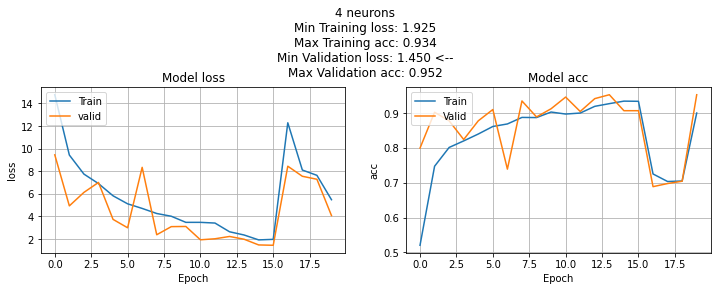

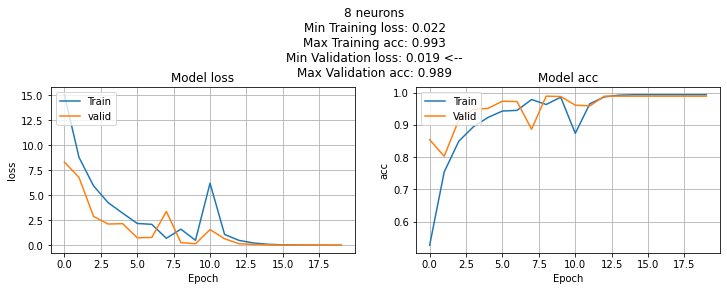

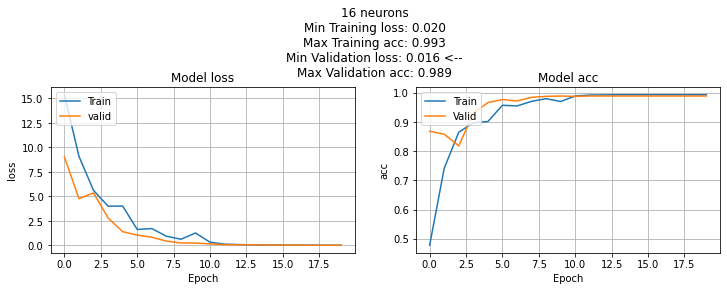

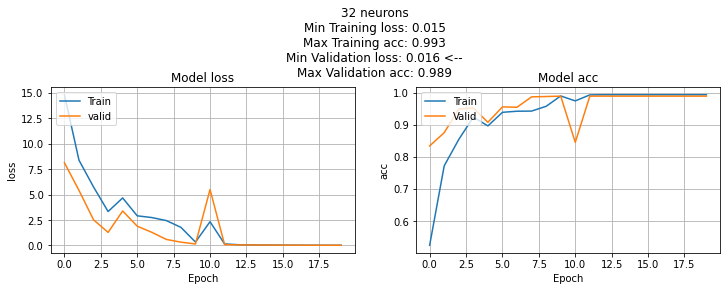

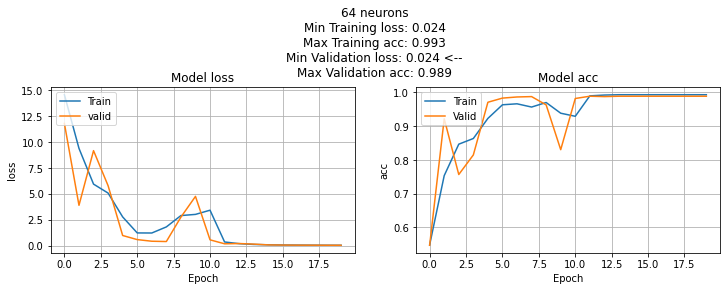

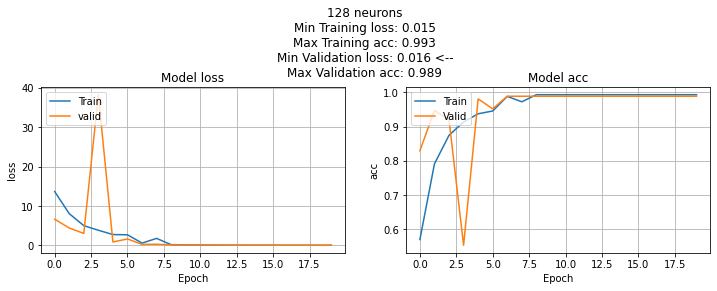

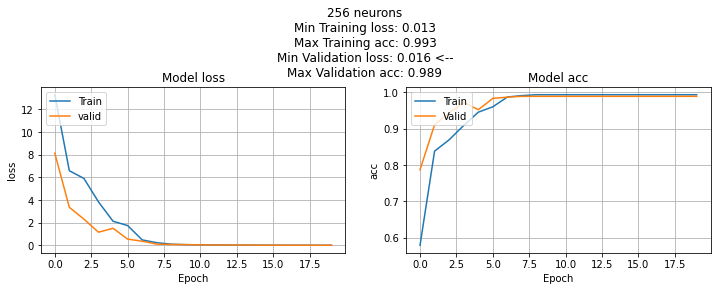

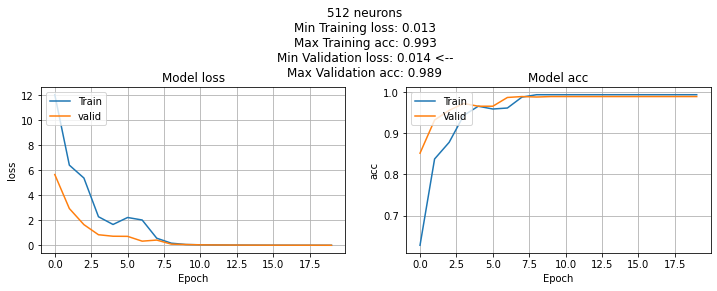

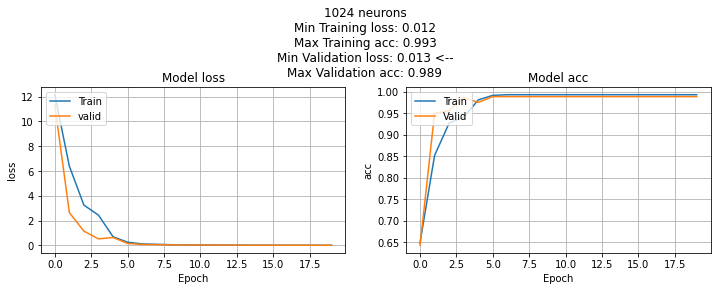

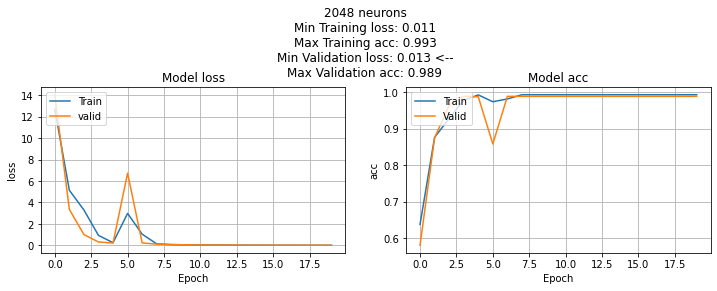

In [17]:
%%time

neurons = [2 ** x for x in list(range(2, 12))]

for neuron in neurons:
    history = run_network(neurons=neuron, summary=True)
    plot(history, f'{neuron} neurons')

### Then, vary depth
Fix `neurons=2048` and vary depth

`hidden_layers=5` yields lowest `valid` loss although:
- `valid` loss from `hidden_layers=4` only slightly underperforms
    - curves are much gentler
    - suggest stabler learning of weights
    - possibly generalizes better
    
#### Complexity
Again, number of parameters
- increases quadratically (approximately)
    - for x hidden layers
    - computation is as follows
        - `(48 + 1) * neuron + (x - 1) * (neuron + 1) * neuron + (neuron + 1) * 3`
        - `+1` is for bias

Although the purpose of this assignment is to find the smallest `valid` error, `hidden_layers=4` will be selected.
- as mentioned above, loss tradeoff is minimal
- ~ 4 million less parameters
    - will train faster and is less likely to overfit

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    --                        --
├─Linear: 1-1                            [16, 2048]                100,352
├─ReLU: 1-2                              [16, 2048]                --
├─Linear: 1-3                            [16, 3]                   6,147
Total params: 106,499
Trainable params: 106,499
Non-trainable params: 0
Total mult-adds (M): 1.70
Input size (MB): 0.00
Forward/backward pass size (MB): 0.26
Params size (MB): 0.43
Estimated Total Size (MB): 0.69
Layer (type:depth-idx)                   Output Shape              Param #
Model                                    --                        --
├─Linear: 1-1                            [16, 2048]                100,352
├─ReLU: 1-2                              [16, 2048]                --
├─Sequential: 1                          --                        --
│    └─Linear: 2-1                       [16, 2048]             

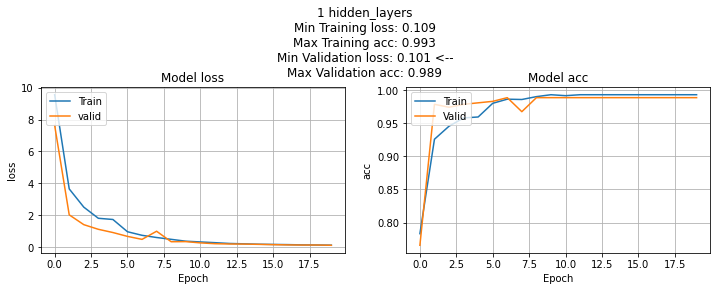

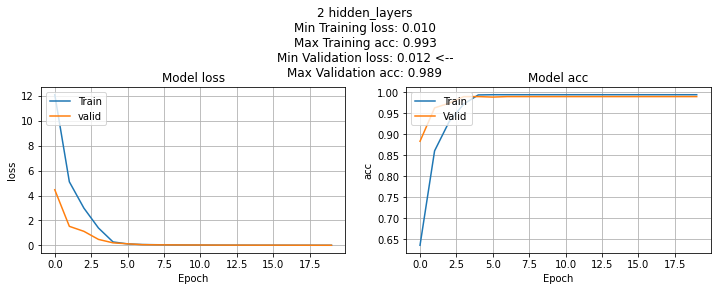

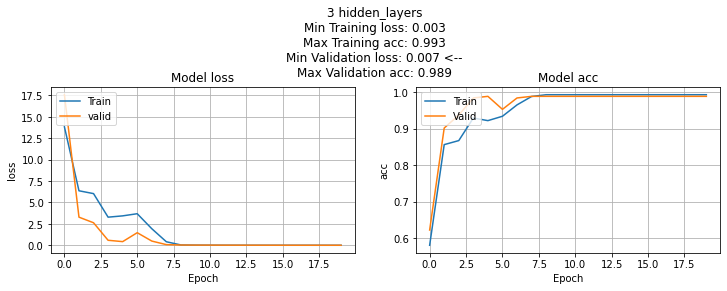

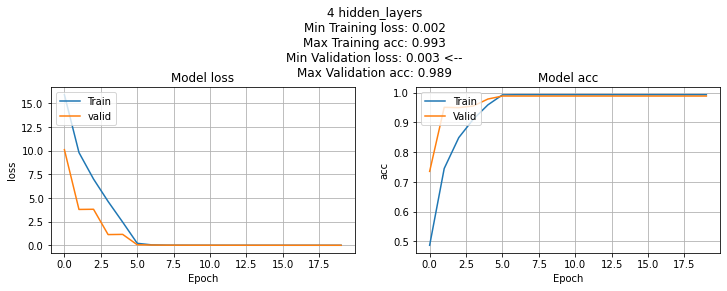

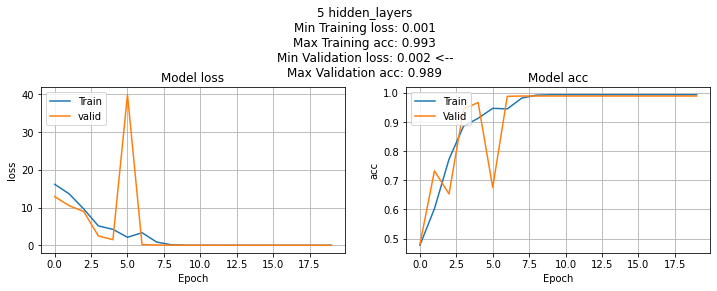

In [18]:
%%time

neurons = 2048
layers = list(range(1, 6))

for hidden_layers in layers:
    history = run_network(neurons=neurons,
                          hidden_layers=hidden_layers,
                          summary=True)
    plot(history, f'{hidden_layers} hidden_layers')

## Task 3
You are asked to study the effect of learning rates. As with Task 2, your experiments have to be well documented. You need to give correct conclusion and give suggestion how learning rates should be
set. This includes possible adaptive learning rates where the value increases or decreases as the
increase of epochs.

### First, vary static learning rate
Fix `hidden_layers=4` and vary `lr`
- `lr=0.01` gives lowest `valid` loss

CPU times: user 2min 8s, sys: 1.02 s, total: 2min 9s
Wall time: 2min 9s


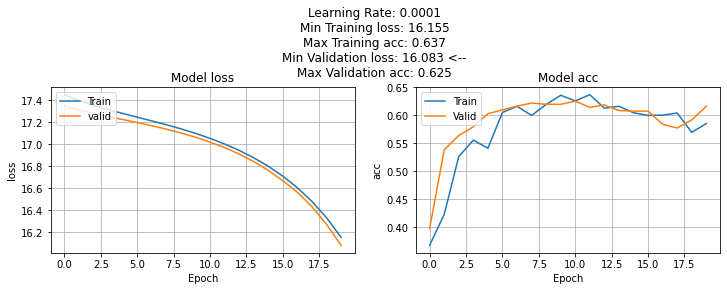

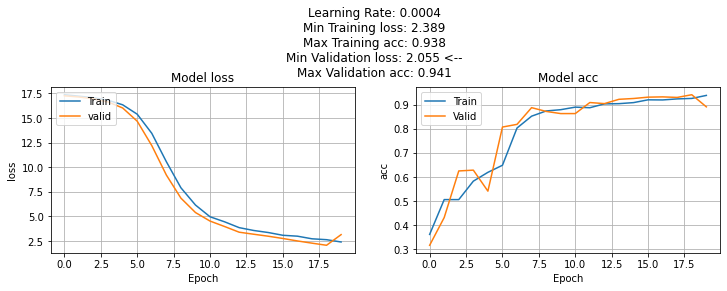

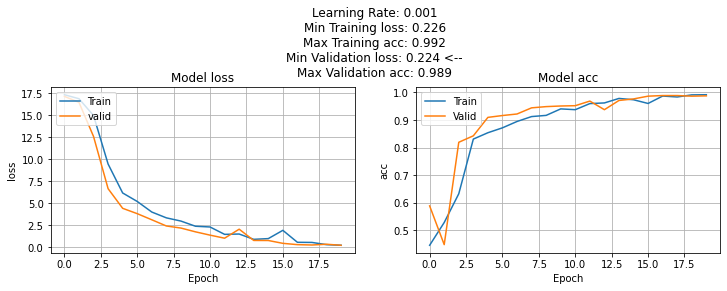

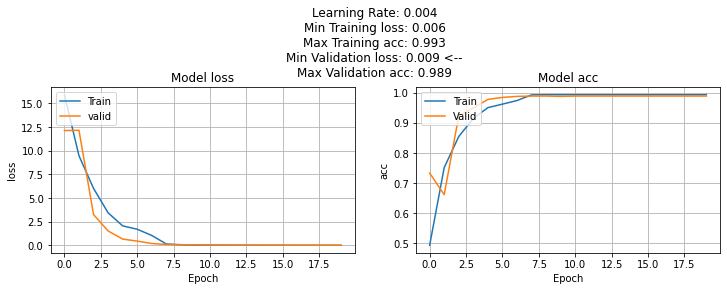

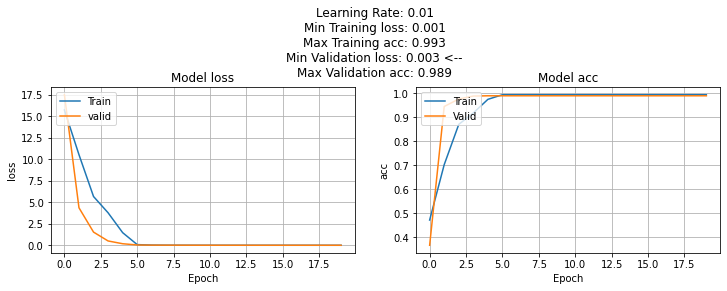

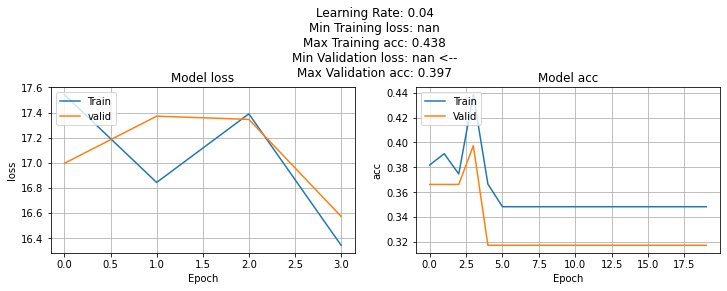

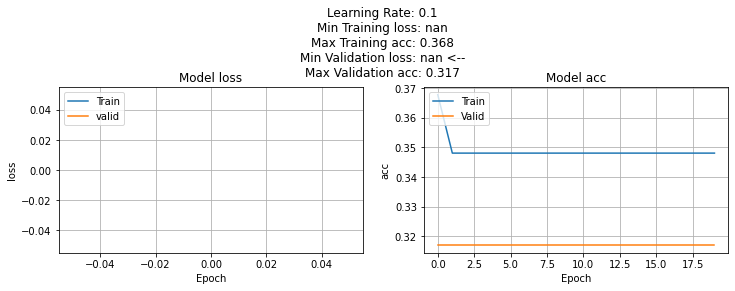

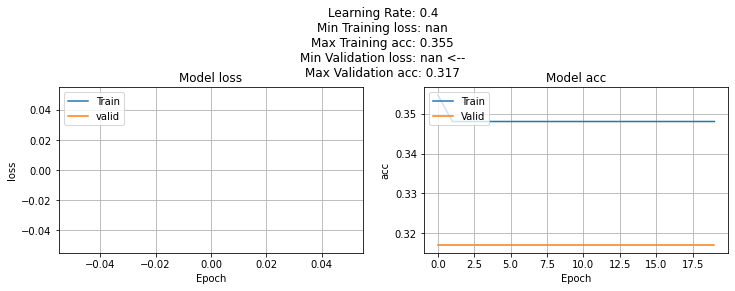

In [19]:
%%time

hidden_layers = 4
lrs = list()
for x in reversed(list(range(1, 5))):
    lrs.append(10 ** -x)
    lrs.append(4 * 10 ** -x)

for lr in lrs:
    history = run_network(neurons=neurons,
                          hidden_layers=hidden_layers,
                          lr=lr)
    plot(history, f'Learning Rate: {lr}')

### Now, vary learning rate with schedule
Scale `lr` by a factor of `gamma` at every `step_size=2`
- `lr=0.01` and `gamma=1` gives lowest `valid` loss
    - static `lr` is best performer in this case
    
Scaling `lr` over time can be effective as:
- as training continues, loss approaches global minimum (ideally)
- to reduce chance of overshooting this minimum
    - reduce `lr` gradually

CPU times: user 10min 25s, sys: 6.67 s, total: 10min 32s
Wall time: 10min 28s


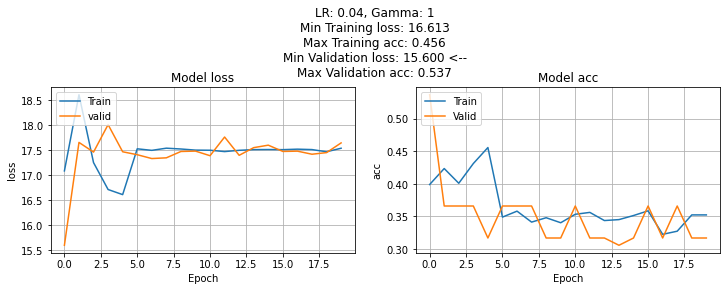

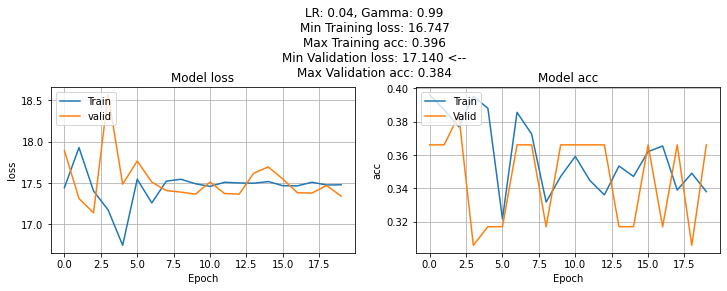

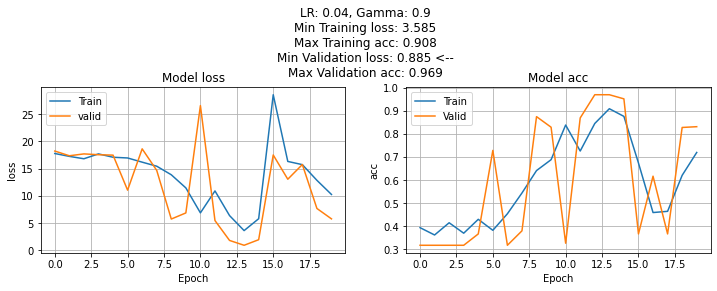

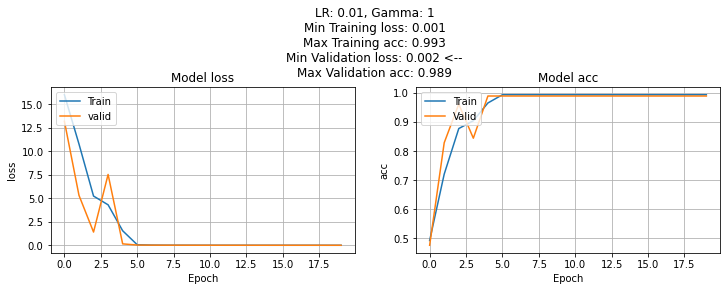

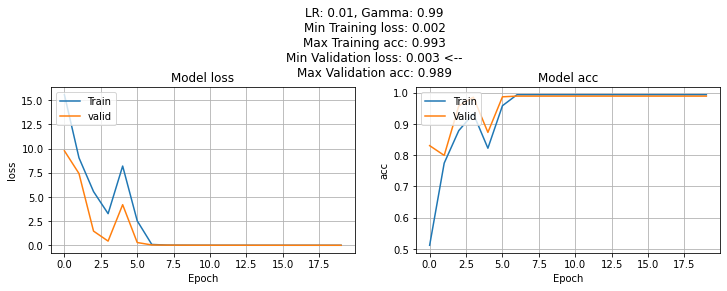

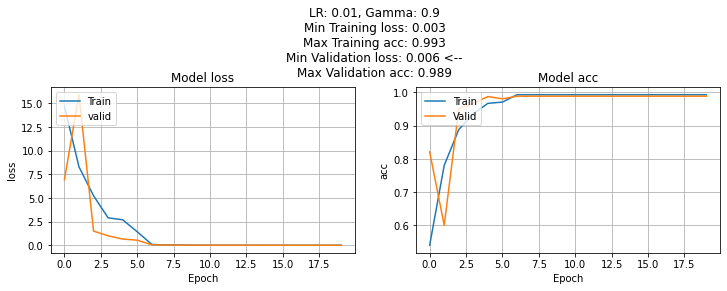

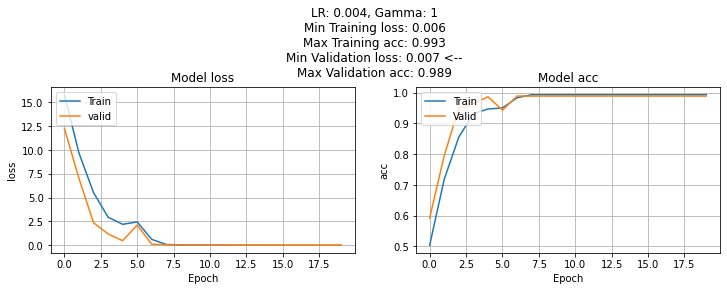

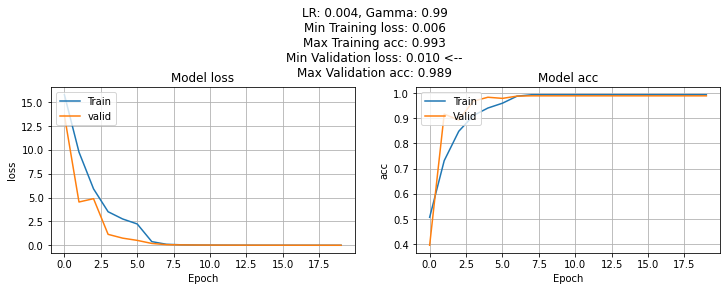

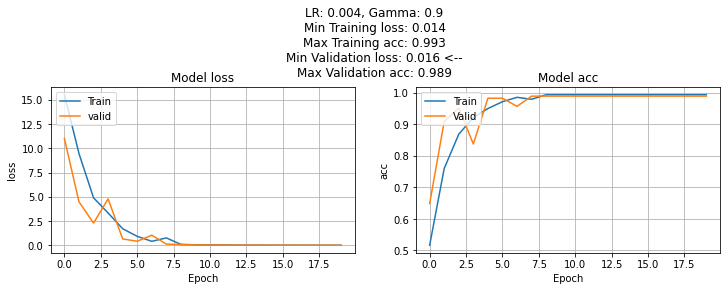

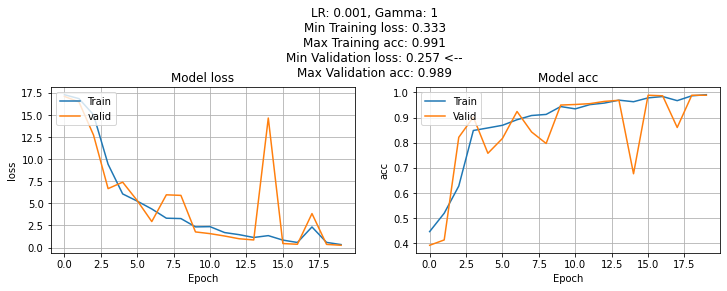

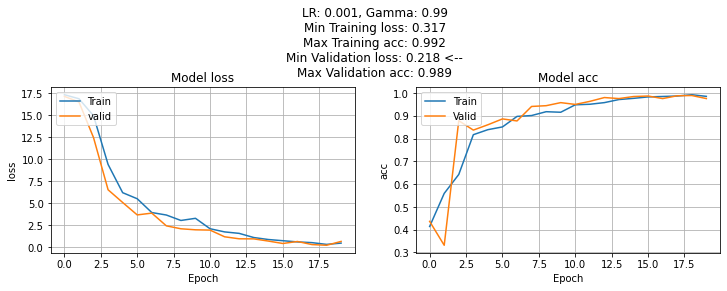

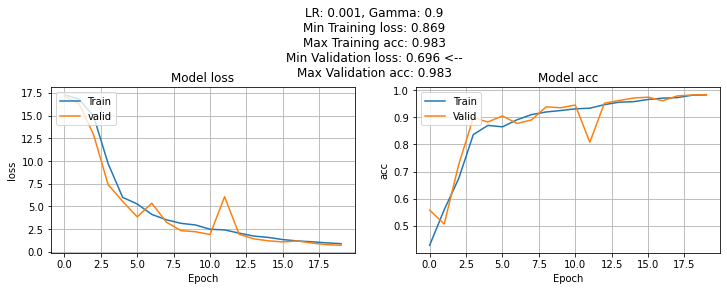

In [20]:
%%time

lrs = [.04, .01, .004, .001]
gammas = [1, .99, .9]

for lr in lrs:
    for gamma in gammas:
        history = run_network(neurons=neurons,
                              hidden_layers=hidden_layers,
                              lr=lr,
                              gamma=gamma)
        plot(history, f'LR: {lr}, Gamma: {gamma}')

## Task 4
You are asked to study the effect of mini-batch size. You can set mini-batch size to be 1 (stochastic
gradient descent), N (batch gradient descent) or any other size. The most important aspect is to be
conclusive with your finding. The mini-batch size really depends on the problem size. 

Since `lr=0.01` and `gamma=1` are already the default values, vary `batch_size` now

`valid` loss is lowest when `batch_size=2`, however:
- it takes the second longest time
    - does not capitalize on parallelization from gpu
    - optimized backend code for matrix multiplication

Batch_size 1 took 1036.057983160019
Batch_size 2 took 556.7814865112305
Batch_size 4 took 280.16515731811523
Batch_size 8 took 159.073668718338
Batch_size 16 took 78.75428366661072
Batch_size 32 took 40.77295279502869
CPU times: user 35min 42s, sys: 24.4 s, total: 36min 7s
Wall time: 35min 51s


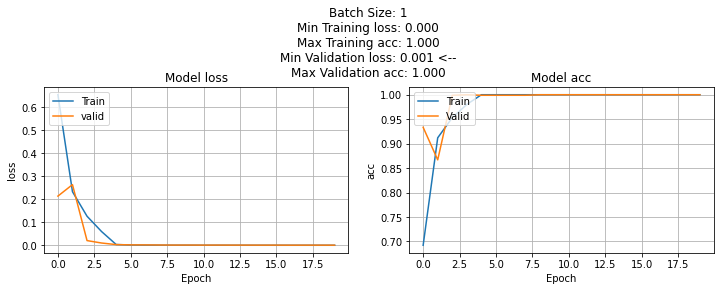

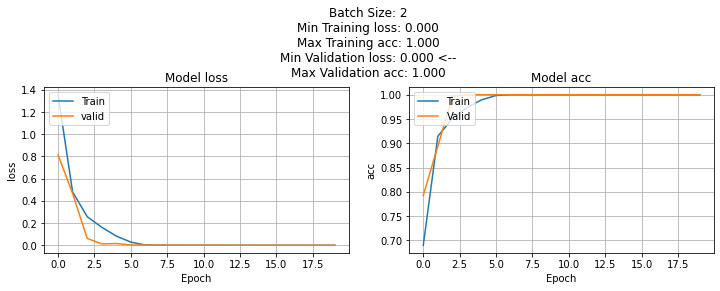

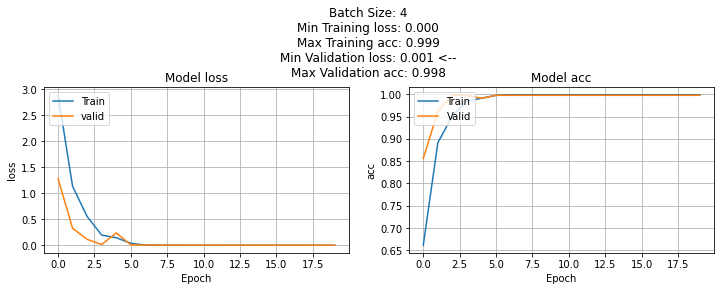

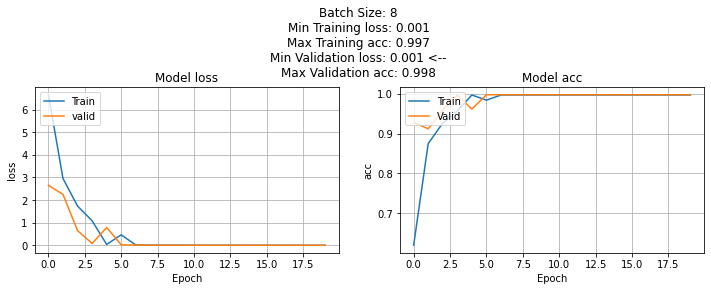

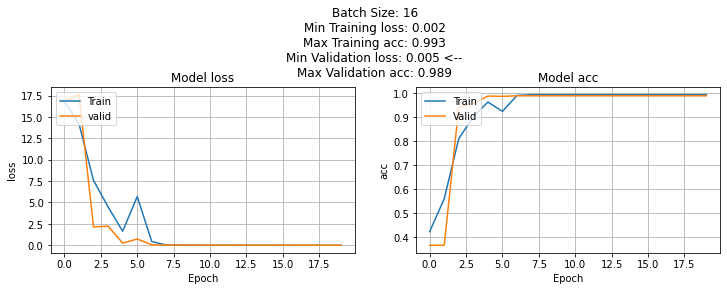

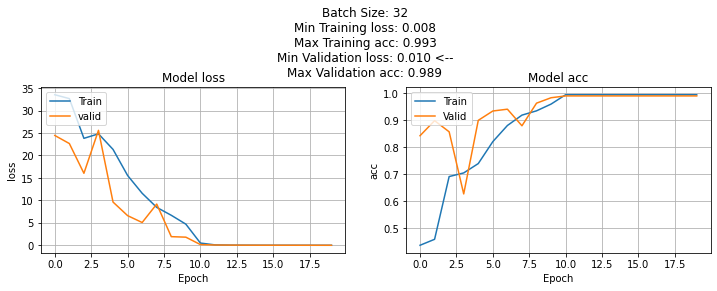

In [21]:
%%time
import time

start_time = time.time()
lr = .01
gamma = .99
batch_sizes = [2 ** x for x in list(range(6))]

for batch_size in batch_sizes:
    history = run_network(neurons=neuron,
                          hidden_layers=hidden_layers,
                          lr=lr,
                          gamma=gamma,
                          batch_size=batch_size)
    plot(history, f'Batch Size: {batch_size}')
    print(f'Batch_size {batch_size} took {time.time() - start_time}')
    start_time = time.time()

## Best Performing (Lowest `valid_loss`)
So far hyperparameters have been varied in isolation. However, varying hyperparameters together can also improve performance as seen [here](https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e).

Further work could focus on varying hyperparameters with
- grid search
- random search

given as example [here](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/)

However for this assignment, the following model yields the loweset `valid_loss`
- where the hyperparameters are guessed with intuition from the above experiments instead of grid or random search
- guess that lesser complexity is better, espcially since the dataset is small

In [22]:
neuron = 64
hidden_layers = 3
lr = .01
batch_size = 16
epochs = 1000

Here cyclic scheduler is used instead of step scheduler
- learning rate is varied from `.01` to `.001` in a periodic manner
- loss has been [shown](https://arxiv.org/pdf/1506.01186.pdf) to converge faster
- smaller network is used
    - reduce training time and chance to overfit
- larger batch size chosen
    - capitalize on gpu parallelization for faster training
- longer epoch
    - allow loss to find global maximum

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    --                        --
├─Linear: 1-1                            [16, 64]                  3,136
├─ReLU: 1-2                              [16, 64]                  --
├─Sequential: 1                          --                        --
│    └─Linear: 2-1                       [16, 64]                  4,160
│    └─ReLU: 2-2                         [16, 64]                  --
│    └─Linear: 2-3                       [16, 64]                  4,160
│    └─ReLU: 2-4                         [16, 64]                  --
├─Linear: 1-3                            [16, 3]                   195
Total params: 11,651
Trainable params: 11,651
Non-trainable params: 0
Total mult-adds (M): 0.19
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.05
Estimated Total Size (MB): 0.07
CPU times: user 3min 6s, sys: 2 s, total: 3min 8s
Wall time: 3min 8s


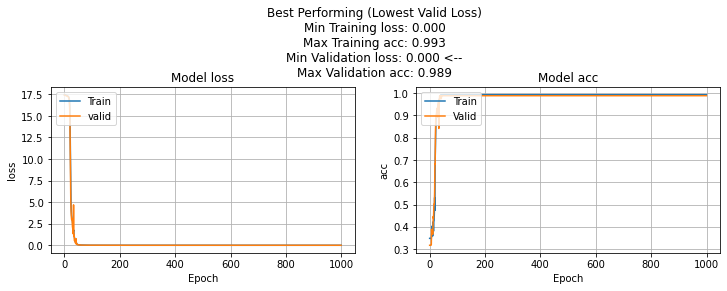

In [23]:
%%time

history = run_network(neurons=neuron,
                      hidden_layers=hidden_layers,
                      lr=lr,
                      batch_size=batch_size,
                      epochs=epochs,
                      scheduler='cyclic',
                      summary=True)
plot(history, 'Best Performing (Lowest Valid Loss)')